# Performance Evaluation of a Ball Tree Using Haversine As a Distance Measure
[This](https://youtu.be/tZDORTtAXmg) video addresses the problem of quickly finding people in close proximity. In the video an approximate distance measure is used and some form of space-partioning data structure was implemented. I was wondering if similar performance (for use in practical scenarios) could be achieved using the exact distance measure and traditional ball trees. As shown below, even without further optimization and on consumer hardware, the problem can be solved for the whole population of Earth.

In [1]:
import timeit

import numpy
import pandas
import sklearn.neighbors
import seaborn

In [2]:
# from: https://stackoverflow.com/questions/38649501/labeling-boxplot-in-seaborn-with-median-value
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects

def add_median_labels(ax):
    lines = ax.get_lines()
    # determine number of lines per box (this varies with/without fliers)
    boxes = [c for c in ax.get_children() if type(c).__name__ == 'PathPatch']
    lines_per_box = int(len(lines) / len(boxes))
    # iterate over median lines
    for median in lines[4:len(lines):lines_per_box]:
        # display median value at center of median line
        x, y = (data.mean() for data in median.get_data())
        # choose value depending on horizontal or vertical plot orientation
        value = x if (median.get_xdata()[1]-median.get_xdata()[0]) == 0 else y
        text = ax.text(x, y, f'{value:.6f}', ha='center', va='center',
                       fontweight='bold', color='white')
        # create median-colored border around white text for contrast
        text.set_path_effects([
            path_effects.Stroke(linewidth=3, foreground=median.get_color()),
            path_effects.Normal(),
        ])

By uniformely sampling the surface of the unit sphere and projecting the coordinated on a sphere with approximate Earth radius, the location of n inhabitans of Earth are simulated.

In [3]:
def generate_samples(n):
    samples = numpy.random.randn(3, n)
    samples /= numpy.linalg.norm(samples, axis=0)
    return samples

In [4]:
def generate_test_sets(sizes=[1_000, 100_000, 10_000_000]):
    R = 6378 # equatorial radius of the Earth
        
    test_sets = dict()
    for n in sizes:
        x, y, z = generate_samples(n) * R
        lat = numpy.arcsin(z / R)
        lon = numpy.arctan2(y, x)
        test_sets[n] = numpy.array(list(zip(lat, lon)))
    return test_sets

In [5]:
test_sets = generate_test_sets()

In [6]:
initialization_durations = dict()
for n in [1_000, 100_000, 10_000_000]:
    initialization_durations[n] = timeit.repeat("sklearn.neighbors.BallTree(test_sets[" + str(n) + "], leaf_size=128, metric='haversine')", globals=globals(), number=1, repeat=8)

In [7]:
measurements = list()
for n in initialization_durations:
    for measurement in initialization_durations[n]:
        measurements.append([n, measurement])
measurements = pandas.DataFrame(measurements, columns=['set size', 'duration'])

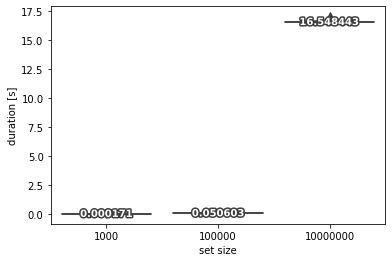

In [8]:
ax = seaborn.boxplot(x='set size', y='duration', data=measurements)
add_median_labels(ax)
ax = ax.set(ylabel='duration [s]')

It can be seen that the cost of constructing the tree grows with the time complexity $O(n \log{n})$.

In [9]:
c = 1/10000000
print(str('set size').rjust(11), 'simulated duration [s]', sep='\t')
for n in [1_000, 100_000, 10_000_000, 10_000_000_000]:
    print(str(n).rjust(11), c * n*numpy.log(n), sep='\t')

   set size	simulated duration [s]
       1000	0.0006907755278982137
     100000	0.11512925464970229
   10000000	16.11809565095832
10000000000	23025.850929940458


For building a tree containing the locations of all Earth inhabitants, a duration of 7 h is expected.

In [10]:
trees = dict()
for n in [1_000, 100_000, 10_000_000]:
    trees[n] = sklearn.neighbors.BallTree(test_sets[n], leaf_size=128, metric='haversine')

In [11]:
def query_random_point(tree):
    query = generate_test_sets(sizes=[1])[1]
    tree.query(query, k=32)

In [12]:
query_durations = dict()
for n in [1_000, 100_000, 10_000_000]:
    query_durations[n] = timeit.repeat("query_random_point(trees[" + str(n) + "])", globals=globals(), number=1, repeat=4096)

In [13]:
query_measurements = list()
for n in query_durations:
    for measurement in query_durations[n]:
        query_measurements.append([n, measurement])
query_measurements = pandas.DataFrame(query_measurements, columns=['set size', 'duration'])

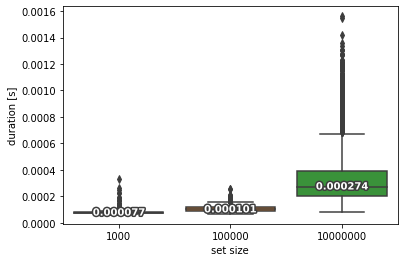

In [14]:
ax = seaborn.boxplot(x='set size', y='duration', data=query_measurements)
add_median_labels(ax)
ax = ax.set(ylabel='duration [s]')

It can be seen that the cost of querying for the n-nearest neighbors grows with time complexity $O(\log{n})$.

In [15]:
c = 1/75000
print(str('set size').rjust(11), 'simulated duration [s]', sep='\t')
for n in [1_000, 100_000, 10_000_000, 10_000_000_000]:
    print(str(n).rjust(11), "{:.7f}".format(c * numpy.log(n)), sep='\t')

   set size	simulated duration [s]
       1000	0.0000921
     100000	0.0001535
   10000000	0.0002149
10000000000	0.0003070


Finding the closest n inhabitants of the Earth takes approximately 0.0003 s.